In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
import sys, os
sys.path.append('/content/drive/MyDrive/')

In [82]:
import unet

In [ ]:
net = unet.unet_model.UNet(n_channels=3, n_classes=10)
net.input_size=(3, 32, 32)
net.num_classes = 10

In [83]:
net

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

print(f"Pytorch version: {torch.__version__}")

# Set the runtime environment to GPU in: Edit -> Notebook settings or Runtime -> Change runtime type  
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Seed random number generator
torch.manual_seed(0)
np.random.seed(0)

Pytorch version: 1.8.0+cu101
Using GPU device: Tesla K80


In [ ]:
def load_and_preprocess_data(dataset_name, batch_size, augment=False):
    """Load, preprocess and return data for training and testing.
    
    Args:
        dataset_name: str, name of dataset from {'mnist', 'cifar10'}.
        batch_size: int, batch size used for training and testing.
        augment: bool, if True, apply data augmentation defined by the augmentation transforms.
    Returns:
        Training and test dataloader objects.
    """

    # Define transformations that will be appied to images
    train_transforms = transforms.Compose([transforms.ToTensor()])
    test_transforms = transforms.Compose([transforms.ToTensor()])

    if augment is True:
        augmentation_transforms = [transforms.RandomCrop(32, padding=4),
                                   transforms.RandomHorizontalFlip(), 
                                   transforms.RandomGrayscale(),
                                   transforms.GaussianBlur((3,3)),
                                   transforms.RandomRotation(np.random.uniform(low=-3.14, high=3.14))]
        train_transforms = transforms.Compose(augmentation_transforms + [transforms.ToTensor()])
        
    # Load train and test datasets
    if dataset_name == 'mnist':
        train_dataset = torchvision.datasets.MNIST(root='./data', 
                                                   train=True,
                                                   download=True, 
                                                   transform=train_transforms)
        test_dataset = torchvision.datasets.MNIST(root='./data', 
                                                  train=False,
                                                  download=True, 
                                                  transform=test_transforms)
    elif dataset_name == 'cifar10':
        train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                                     train=True,
                                                     download=True, 
                                                     transform=train_transforms)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                                    train=False,
                                                    download=True, 
                                                    transform=test_transforms)
    else:
        raise Exception("The dataset name must be element of {'mnist', 'cifar10'}.")

    # Create dataset loaders
    trainset_loader = torch.utils.data.DataLoader(train_dataset, 
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=2)
    testset_loader = torch.utils.data.DataLoader(test_dataset, 
                                                 batch_size=batch_size,
                                                 shuffle=False, 
                                                 num_workers=2)

    # Print data info
    print(f"Dataset: {dataset_name} \n", 
          f"Image shape: {train_dataset[0][0].numpy().shape} \n",
          f"Number of train images: {len(train_dataset)} \n",
          f"Number of test images: {len(test_dataset)} \n",
          f"Number of classes: {len(np.unique(train_dataset.targets))} \n")
    
    # Visualize a batch of input examples 
    images, labels = iter(trainset_loader).next()
    image_grid = torchvision.utils.make_grid(images)
    plt.imshow(np.transpose(image_grid, (1, 2, 0)))
    plt.axis('off')
    plt.show()

    return (trainset_loader, testset_loader)


In [ ]:
def training_and_eval(dataset_name, model, optimizer, batch_size, num_epochs, augment=False):
    """Training and testing.
    
    Args:
        dataset_name: str, name of dataset from {'mnist', 'cifar10'}.
        model: instance of MLPModel or CNNModel class.
        optimizer: instance of any optimizer defined in the torch.nn.optim module.
        batch_size: int, batch size used for training and testing.
        num_epochs: int, number of training epochs.

        augment: bool, if True, apply augmentation transforms in load_and_preprocess_data function.
    Returns:
        model: a trained model that is instance of MLPModel or CNNModel class.
        history: dict that contains the loss and accuracy history.
    """

    # Function to calculate accuracy
    def get_accuracy(prediction, target, batch_size):
        corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
        accuracy = 100.0 * corrects / batch_size
        return accuracy.item()

    # Get the train and test data
    train_loader, test_loader = load_and_preprocess_data(dataset_name, 
                                                         batch_size, 
                                                         augment=augment)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Train the model
    history = {'train_loss': [],
               'train_accuracy': [],
               'test_loss': [],
               'test_accuracy': []}

    print(f"Model summary")
    summary(model, input_size=model.input_size)
    print(f"Train the model on {dataset_name} dataset for {num_epochs} epochs...\n")

    device = torch.cuda.current_device()
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        model = model.train()

        # Train
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass + backprop + loss calculation
            predictions = model(images)
            loss = loss_function(predictions, labels)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_loss += loss.detach().item()
            train_acc += get_accuracy(predictions, labels, batch_size)

        model.eval()
        train_loss = train_loss / (i+1)
        train_acc = train_acc / (i+1)
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Train accuracy: {train_acc}")  

        # Evaluate on test set
        test_loss = 0.0
        test_acc = 0.0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            loss = loss_function(predictions, labels)
            test_loss += loss.detach().item()
            test_acc += get_accuracy(predictions, labels, batch_size)
        test_loss = test_loss / (i+1)
        test_acc = test_acc / (i+1)
        print(f" \t  Test loss: {test_loss} | Test accuracy: {test_acc}") 

        # Add results to the history dict
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)
   
    return model, history


In [ ]:
# 2. Define the CNN model class 

class CNNModel2(nn.Module):
    def __init__(self, input_size=(3, 32, 32), num_classes=10):
        super(CNNModel2, self).__init__()
        self.input_size = input_size
        kernel_size, padding, padding_mode = (3,3), 1, 'replicate'
        # TODO
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, stride=1, padding=padding, padding_mode=padding_mode)
        self.bnorm1 = nn.BatchNorm2d(num_features=64)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=1, padding=padding, padding_mode=padding_mode)
        self.bnorm2 = nn.BatchNorm2d(num_features=128)
        self.act2 = nn.ReLU()
        self.dout1 = nn.Dropout(p=.3)
        self.layer3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel_size, stride=2, padding=padding, padding_mode=padding_mode)
        self.bnorm3 = nn.BatchNorm2d(num_features=128)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size, stride=1, padding=padding, padding_mode=padding_mode)
        self.bnorm4 = nn.BatchNorm2d(num_features=256)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel_size, stride=2, padding=padding, padding_mode=padding_mode)
        self.bnorm5 = nn.BatchNorm2d(num_features=256)
        self.act5 = nn.ReLU()
        self.dout2 = nn.Dropout(p=.3)
        self.layer6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=kernel_size, stride=1, padding=padding, padding_mode=padding_mode)
        self.bnorm6 = nn.BatchNorm2d(num_features=512)
        self.act6 = nn.ReLU()
        self.layer7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=kernel_size, stride=2, padding=padding, padding_mode=padding_mode)
        self.bnorm7 = nn.BatchNorm2d(num_features=512)
        self.act7 = nn.ReLU()
        self.layer8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=kernel_size, stride=1, padding=padding, padding_mode=padding_mode)
        self.bnorm8 = nn.BatchNorm2d(num_features=512)
        self.act8 = nn.ReLU()
        self.dout3 = nn.Dropout(p=.3)
        self.layer9 = nn.AvgPool2d(kernel_size = kernel_size) 
        self.layer10 = nn.Flatten()
        self.layer11 = nn.Linear(in_features=512, out_features=256)
        self.act11 = nn.ReLU()        
        self.layer12 = nn.Linear(in_features=256, out_features=num_classes)

        self.output = nn.Softmax()
        #self.layer3 = 
        #self.output = 

        self.layers = [self.layer1,
                       self.bnorm1,
                       self.act1,
                       self.layer2,
                       self.bnorm2,
                       self.act2,
                       self.dout1,
                       self.layer3,
                       self.bnorm3,
                       self.act3,
                       self.layer4,
                       self.bnorm4,
                       self.act4,
                       self.layer5,
                       self.bnorm5,
                       self.act5,
                       self.dout2,
                       self.layer6,
                       self.bnorm6,
                       self.act6,
                       self.layer7,
                       self.bnorm7,
                       self.act7,
                       self.layer8, 
                       self.bnorm8,
                       self.act8,
                       self.dout3, 
                       self.layer9,
                       self.layer10,
                       self.layer11,
                       self.act11,
                       self.layer12,
                       self.output]
  

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


Files already downloaded and verified
Files already downloaded and verified
Dataset: cifar10 
 Image shape: (3, 32, 32) 
 Number of train images: 50000 
 Number of test images: 10000 
 Number of classes: 10 



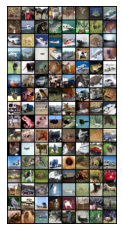

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
        DoubleConv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14     

RuntimeError: ignored

In [ ]:

DATASET_NAME = 'cifar10'
MODEL = net.to(torch.cuda.current_device())
 
# TODO
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=1e-5)  
BATCH_SIZE = 128  
NUM_EPOCHS = 200 

trained_model, loss_and_accuracy_history = training_and_eval(DATASET_NAME, 
                                                             MODEL,
                                                             OPTIMIZER,
                                                             BATCH_SIZE, 
                                                             NUM_EPOCHS,
                                                             augment = False)

In [ ]:
summary(MODEL, MODEL.input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
        DoubleConv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

Files already downloaded and verified
Files already downloaded and verified
Dataset: cifar10 
 Image shape: (3, 32, 32) 
 Number of train images: 50000 
 Number of test images: 10000 
 Number of classes: 10 



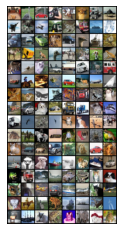

In [ ]:
train, test = load_and_preprocess_data("cifar10", BATCH_SIZE)

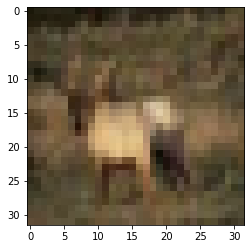

In [ ]:
plt.imshow((train.dataset.data[3]/256))

In [ ]:
train.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [1]:
train.dataset.data[1]/256

NameError: ignored